<a href="https://colab.research.google.com/github/RiviereKevin/machine_prediction_failure/blob/main/Prediction_fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Read in the maze from a CSV file
#df = pd.read_csv("/content/data3.csv")

import pandas as pd
import seaborn as sns
import sklearn.metrics as metrique
from pandas import Series
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.layers import LSTM, Dense, Embedding, Dropout, Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten, RepeatVector, Activation, Lambda
from keras import backend as K, regularizers, metrics
from keras.backend import cast
import chardet

with open('data3.csv', 'rb') as f:
    result = chardet.detect(f.read())

print(result['encoding'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ISO-8859-1


In [81]:
data = pd.read_csv('data3.csv', encoding=result['encoding'])

The data was enconded, I decided to import a package 'chardet', documentation describe this package as 'The Universal Character Encoding Detector'. Then I was able to open and then we can print the first five rows of our dataset.

In [82]:
data.head(5)

,Unnamed: 0,ï..UDI,Product.ID,Type,Air.temperature,Process.temperature,Rotational.speed,Torque,Tool.wear,Machine.failure
0,1925,1925,L49104,L,297.9,307.7,1353,50.7,13,0
1,3203,3203,L50382,L,300.2,309.2,1430,43.4,24,0
2,3783,3783,L50962,L,302.2,310.8,1827,23.8,9,0
3,1757,1757,M16616,M,298.1,307.4,1363,60.1,187,0
4,1674,1674,M16533,M,298.1,307.8,1384,43.7,200,0


Let's note that 'y' - or target variable is 'Machine.failure'
It's good to have a view of the type of our variables, if they are 'int', 'float', 'string'...

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5000 non-null   int64  
 1   ï..UDI               5000 non-null   int64  
 2   Product.ID           5000 non-null   object 
 3   Type                 5000 non-null   object 
 4   Air.temperature      5000 non-null   float64
 5   Process.temperature  5000 non-null   float64
 6   Rotational.speed     5000 non-null   int64  
 7   Torque               5000 non-null   float64
 8   Tool.wear            5000 non-null   int64  
 9   Machine.failure      5000 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 390.8+ KB


In [84]:
#Checking for any null values and removing the null values
print('Null Values =',data.isnull().values.any())
print('NA Values =',data.isna().values.any())

Null Values = False
NA Values = False


Double check to see if the dataset has any Null or Na values. We can see that it is not the case, no transformation needed.

# Data Visualisation

As the data is now cleaned and loaded we can start the exploration of it, and understand the distribution of some variable, to better understand potential issues, this process can help to build the best model of prediction.

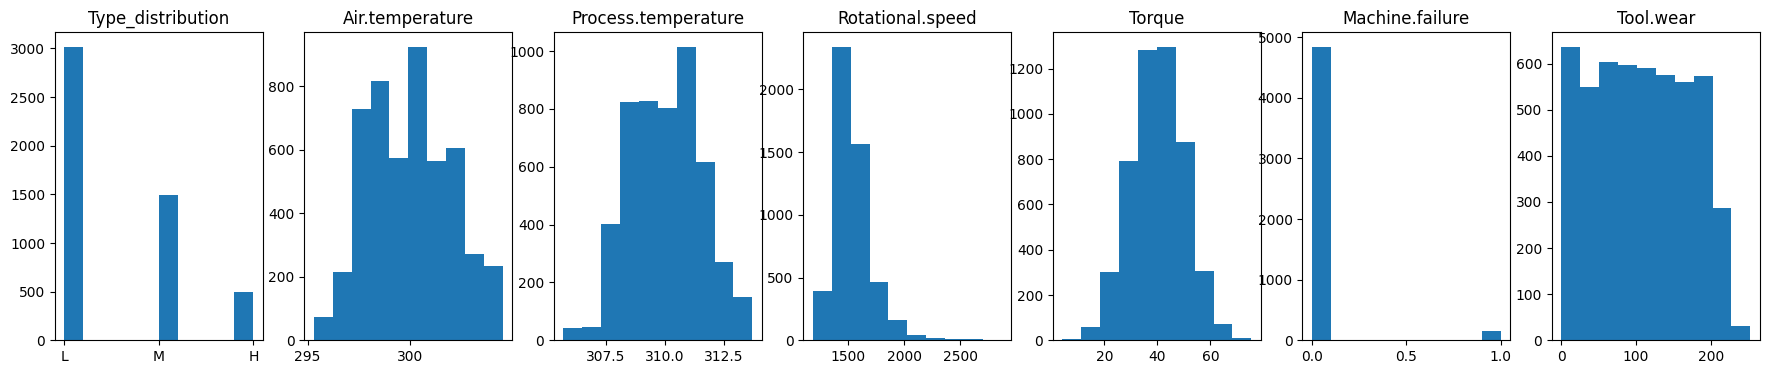

In [85]:
fig, axs = plt.subplots(1, 7, figsize=(22, 4))

# Plot data on each subplot
axs[0].hist(data['Type'])
axs[1].hist(data['Air.temperature'])
axs[2].hist(data['Process.temperature'])
axs[3].hist(data['Rotational.speed'])
axs[4].hist(data['Torque'])
axs[5].hist(data['Machine.failure'])
axs[6].hist(data['Tool.wear'])

# Set title 
axs[0].set_title('Type_distribution')
axs[1].set_title('Air.temperature')
axs[2].set_title('Process.temperature')
axs[3].set_title('Rotational.speed')
axs[4].set_title('Torque')
axs[5].set_title('Machine.failure')
axs[6].set_title('Tool.wear')
plt.show()

We can see that, TYPE is not well distributed, indeed "L" stand for "Low quality" represents the wide majority of the products. We can now imagine that "low quality product" is the variable most likely to be damaged and fail in the future, has it might be exposed to high rotational speed, high temperature, the lowest quality products might represent the highest fail rate. And to predict, other variables this charts can illustrate us an idea of the distribution and better undertanding of the under which condition are set the products.

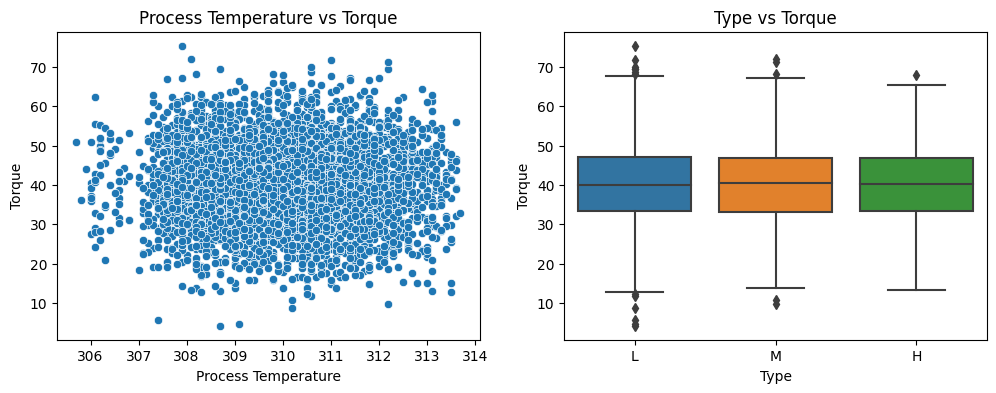

In [86]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
# First plot
sns.scatterplot(x='Process.temperature', y='Torque', data=data, ax=axs[0])
axs[0].set_title('Process Temperature vs Torque')
axs[0].set_xlabel('Process Temperature')
axs[0].set_ylabel('Torque')
# Second plot
sns.boxplot(x='Type', y='Torque', data=data, ax=axs[1])
axs[1].set_title('Type vs Torque')
axs[1].set_xlabel('Type')
axs[1].set_ylabel('Torque')
plt.show()


This visualisation can help us to understand if there is any relationship beetween these varaibles. Here, our first graph 'Process Temperature vs Torque' no particular relationship. And the second graph, 'Type vs Torque' good distriubution of 'L','M' and "H" by the torque, no major comment nor special attention of the relationship of the variables.

In [87]:
# Group the data by type and and Machine Failure = (our target variable)
grouped_data = data.groupby(['Machine.failure', 'Type']).size().reset_index(name='count')
print(grouped_data)

   Machine.failure Type  count
0                0    H    485
1                0    L   2902
2                0    M   1452
3                1    H      9
4                1    L    113
5                1    M     39


Let's have a better view of how much that represent in percentage

In [88]:
total_count = grouped_data['count'].sum()
grouped_data['proportion'] = (grouped_data['count'] / total_count) * 100
print(grouped_data)

   Machine.failure Type  count  proportion
0                0    H    485        9.70
1                0    L   2902       58.04
2                0    M   1452       29.04
3                1    H      9        0.18
4                1    L    113        2.26
5                1    M     39        0.78


Our assumption is good, Low quality products are more likely to be defaulted.

# Planning model 

In [89]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from collections import Counter
from matplotlib import pyplot
from numpy import where

The main data exploration is now done. We can move to a first potential prediction. As the number of variables seems to be reasonable and our 'y' (target variable) is a dichotomous variable we can imagine that linear regression is the potential candidate for this model, let's start.

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5000 non-null   int64  
 1   ï..UDI               5000 non-null   int64  
 2   Product.ID           5000 non-null   object 
 3   Type                 5000 non-null   object 
 4   Air.temperature      5000 non-null   float64
 5   Process.temperature  5000 non-null   float64
 6   Rotational.speed     5000 non-null   int64  
 7   Torque               5000 non-null   float64
 8   Tool.wear            5000 non-null   int64  
 9   Machine.failure      5000 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 390.8+ KB


First thing first we need to encode some varaibles as they are object, here we have 'Type' and 'Product ID'. We do it with 'One Hot'package.

In [91]:
# I use One-Hot Encode 
cat_features = ['Type',	'Product.ID']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data[cat_features])
encoded_features = enc.transform(data[cat_features]).toarray()
data.drop(cat_features, axis=1, inplace=True)
data = pd.concat([data, pd.DataFrame(encoded_features)], axis=1)

In [92]:
X = data.drop(['Machine.failure'], axis = 'columns')
Label_Data = data['Machine.failure']

In [93]:
# Generate and print imbalanced classification dataset
counter = Counter(data['Machine.failure'])
print(counter)
for label, _ in counter.items():
	row_ix = where(data['Machine.failure'] == label)[0]

Counter({0: 4839, 1: 161})


and we 'print(counter)' to see if our target variable is well defined. At this point the encoding is done, and the counter of failure or not failure is correct. We can now go further to our logistic model, and to start to seperate our data, basic process we take "80% for the train and logically 20% for the test".

In [94]:
# Basic sheme I split the data into training and testing sets 80% and 20%
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

To avoid any imbalanced issue we need to rajust our data 

In [95]:
# Convert feature names to strings
X.columns = X.columns.astype(str)
over_sampler = RandomOverSampler()
X_r, y = over_sampler.fit_resample(X, data['Machine.failure'])

In [96]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_r, y = oversample.fit_resample(X, data['Machine.failure'])
# summarize the new class distribution
counter = Counter(y)
print(counter)

for label, _ in counter.items():
	row_ix = where(y == label)[0]
from sklearn.preprocessing import StandardScaler
## Standardizing the data
X_r2 = StandardScaler().fit_transform(X_r)
X_train,X_test,y_train,y_test = train_test_split(X_r2, y, test_size=0.2)

Counter({0: 4839, 1: 4839})


I used both RandomOverSampler and SMOTE, I have increased the number of samples in the lower class, which might help my model to learn and better distinguish between the two classes and avoid over/under sampling.
Let us have look to the shave of our train & test models :

In [97]:
X_train.shape

(7742, 5010)

In [98]:
X_test.shape

(1936, 5010)

# Logistic Regression 

The code is better balanced, and then the model can be applied. As stated before Logistic Regression seems to be a reasonable choice. Indeed, Logistic regression is commonly used for binary classification problems. Where twe are lokking for the predictability the probability of a binary outcome. In this dataset, the binary outcome is whether or not the machine failure occurred, which is indicated by the 'Machine.failure' column.

Logistic regression models can be used both for continuous and categorical input features, and we do have it in this dataset because there are multiple input features that have numerical values, such as Air.temperature, Process.temperature, Rotational.speed, Torque, and Tool.wear, as well as categorical features such as Product.ID and Type.

On top of that, logistic regression has the advantage of being a simple and interpretable model. It allows us to understand the relationship between each input feature and the predicted outcome, and the coefficients of the logistic regression model can provide insight into which features are most important in predicting machine failure.

In [99]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Text(0.5, 1.0, 'Logistic Regression')

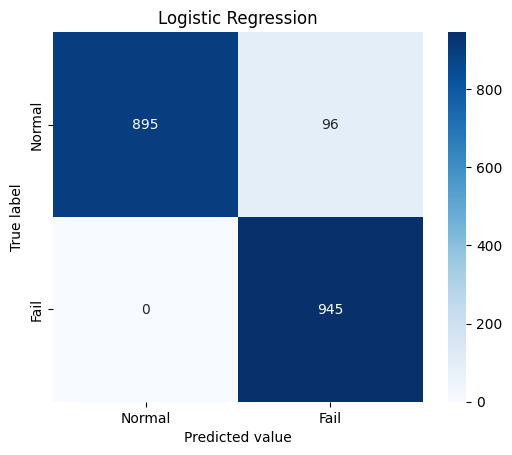

In [100]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns_plot = sns.heatmap(cm, annot=True, fmt='g', xticklabels=['Normal', 'Fail'], yticklabels=['Normal', 'Fail'], cmap='Blues', cbar=True, square=True)
sns_plot.set_xlabel('Predicted value')
sns_plot.set_ylabel('True label')
sns_plot.set_title('Logistic Regression')


In [101]:
# Calculate recall and precision
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

Accuracy: 0.950413
Precision: 0.907781
Recall: 1.000000
F1 score: 0.951662


In [102]:
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.90768238 0.92575855 0.9127907  0.91795866 0.91989664]
Mean cross-validation score: 0.9168173848928124


Regarding the output, the cross-validation scores and the mean cross-validation score. Here, we do have the mean cross-validation score very close to the training accuracy, this indication illustrate that the model is not overfitting. 

We talk about overfitting when : the mean cross-validation score is significantly lower than the training accuracy, it suggests that the model is overfitting.

# Comparaison Random Forest & Logistic Regression

To have better vision of prediction, I decide to choose a second model, as I previously used a Supervised Method, I can see the prediction of a unsupervised model, to do so I use Random Forest, it is a very common model but it can be very efficient in this dataset, let's compare the two models

In [103]:
from sklearn.ensemble import RandomForestClassifier
# Run the train and the test for a random forest 
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred_rf = rfc.predict(X_test)

Text(0.5, 1.0, 'Random Forest')

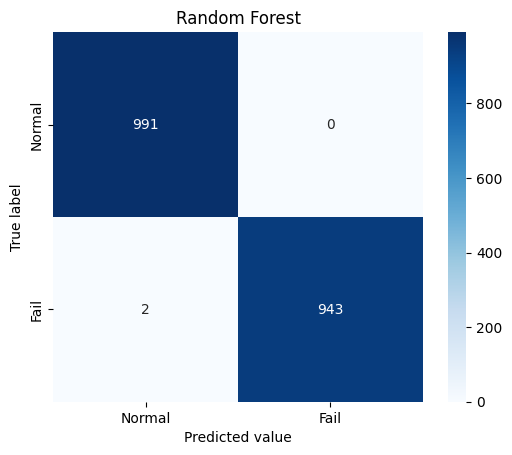

In [104]:
# Same process to evaluate the model I plot the the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns_plot_rf = sns.heatmap(cm_rf, annot=True, fmt='g', xticklabels=['Normal', 'Fail'], yticklabels=['Normal', 'Fail'], cmap='Blues', cbar=True, square=True)
sns_plot_rf.set_xlabel('Predicted value')
sns_plot_rf.set_ylabel('True label')
sns_plot_rf.set_title('Random Forest')

In [105]:
# Then I use the metrics in order to print the main score :
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print('Random Forest Model Evaluation Metrics')
print('Accuracy: %f' % accuracy_rf)
print('Precision: %f' % precision_rf)
print('Recall: %f' % recall_rf)
print('F1 score: %f' % f1_rf)

Random Forest Model Evaluation Metrics
Accuracy: 0.998967
Precision: 1.000000
Recall: 0.997884
F1 score: 0.998941


In [106]:
# And finnaly as did before with the Logisitc Regression we use the cross validation score and the Mean cross score : 
clf_lr = LogisticRegression(random_state=42)
scores_lr = cross_val_score(clf_lr, X_train, y_train, cv=5)
print("Logistic Regression Cross-validation scores:", scores_lr)
print("Mean Logistic Regression cross-validation score:", scores_lr.mean())
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
scores_rf = cross_val_score(clf_rf, X_train, y_train, cv=5)
print("Random Forest Cross-validation scores:", scores_rf)
print("Mean Random Forest cross-validation score:", scores_rf.mean())

Logistic Regression Cross-validation scores: [0.90768238 0.92575855 0.9127907  0.91795866 0.91989664]
Mean Logistic Regression cross-validation score: 0.9168173848928124
Random Forest Cross-validation scores: [0.99677211 0.9941898  0.99741602 0.99677003 0.99935401]
Mean Random Forest cross-validation score: 0.9969003925179702


The evaluation metrics for the random forest classifier are better than   the logistic regression one. We observe that the the random forest model has higher accuracy, precision, recall, and F1 score on the test set. On top of that, the cross-validation scores for the random forest model are higher and consistant than those for the logistic regression model, which shows a better generalization performance. In this case, the random forest model seems to be a better choice than logistic regression.

# Recomendation and Insights  

With those models we get clear information wheater a product will fail or not.

Indeed, our 'air temperature', 'process temperature', 'rotational speed', 'torque', and 'tool wear' are really important to monitor in order to reduce the probablity of failure.

Each variables count in this process, however it seems that the 3 most important variables the company most take care of and monitoring are : Torque , Rotational Speed and Tool wear

In [107]:
importances = rfc.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

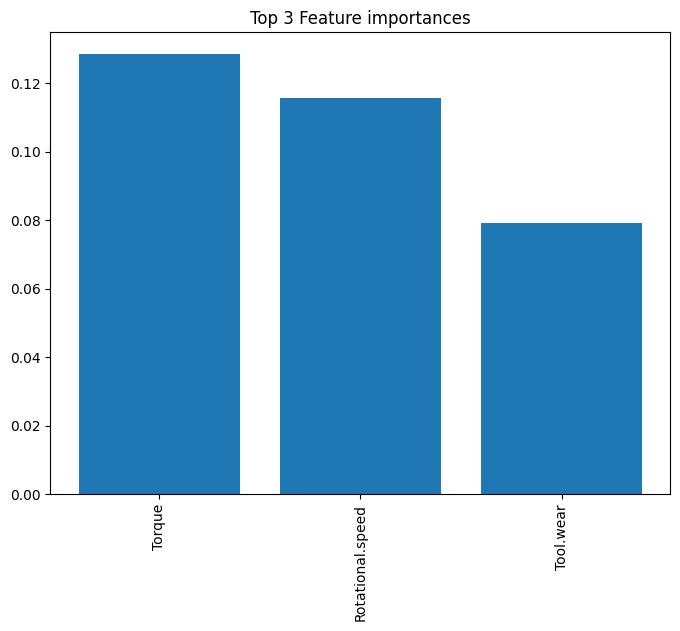

In [108]:
# Get the top 3 most important varaibles
top_indices = indices[:3]
top_features = feature_names[top_indices]
top_importances = importances[top_indices]

# Plot feature importances
plt.figure(figsize=(8,6))
plt.title("Top 3 Feature importances")
plt.bar(range(len(top_importances)), top_importances)
plt.xticks(range(len(top_importances)), top_features, rotation=90)
plt.show()


Torque counts for 14%, Rotational Speed 11% and Tool Wear 9%.